In [2]:
###############
### IMPORTS ###
###############

from scipy.io import readsav
import numpy as np
from aiapy.calibrate import degradation, register, update_pointing
from astropy.io import fits
from sunpy.net import Fido, attrs
import sunpy.map
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [18]:
# Set the date of your dataset:
date='20140313'

In [4]:
datadir='./data/'

In [5]:
# Read-in AIA fits files. These are level 2 cropped files produced by LMSAL (AIA 1.5 level co-aligned with IRIS)
fcube304 = fits.open(datadir+'AIA20140313_232407_0304.fits',mode='readonly')
fcube335 = fits.open(datadir+'AIA20140313_232402_0335.fits',mode='readonly')
fcube131 = fits.open(datadir+'AIA20140313_232408_0131.fits',mode='readonly')
fcube171 = fits.open(datadir+'AIA20140313_232359_0171.fits',mode='readonly')
fcube193 = fits.open(datadir+'AIA20140313_232406_0193.fits',mode='readonly')
fcube211 = fits.open(datadir+'AIA20140313_232359_0211.fits',mode='readonly')
fcube094 = fits.open(datadir+'AIA20140313_232401_0094.fits',mode='readonly')

In [6]:
data304 = fcube304[0].data
data304 = data304.astype(float, copy=False)
hdr304 = fcube304[0].header
data335 = fcube335[0].data
data335 = data335.astype(float, copy=False)
hdr335 = fcube335[0].header
data131 = fcube131[0].data
data131 = data131.astype(float, copy=False)
hdr131 = fcube131[0].header
data171 = fcube171[0].data
data171 = data171.astype(float, copy=False)
hdr171 = fcube171[0].header
data193 = fcube193[0].data
data193 = data193.astype(float, copy=False)
hdr193 = fcube193[0].header
data211 = fcube211[0].data
data211 = data211.astype(float, copy=False)
hdr211 = fcube211[0].header
data094 = fcube094[0].data
data094 = data094.astype(float, copy=False)
hdr094 = fcube094[0].header

In [13]:
# Read-in exposure times:
expt304=hdr304['EXPTIME']
expt094=hdr094['EXPTIME']
expt131=hdr131['EXPTIME']
expt171=hdr171['EXPTIME']
expt193=hdr193['EXPTIME']
expt211=hdr211['EXPTIME']
expt335=hdr335['EXPTIME']

In [14]:
#normalise with respect to exposure time:
data304=data304/expt304
data094=data094/expt094    
data131=data131/expt131
data171=data171/expt171
data193=data193/expt193
data211=data211/expt211
data335=data335/expt335

In IDL:
Produce the AIA temperature response function with SSWIDL with the following keywords:

    aia_resp = aia_get_response(/dn,/temp,/chiantifix,/eve,timedepend_date=date)

Save the structure into an IDL save file:

    ex = 'save,aia_resp,filename='+'"'datadir+'aia_resp_'+date+'.sav'+'"'
    void = execute(ex)

In [15]:
#RFit method
def get_response(date):
    # FAUCHERE FUNCTION

    sav_of_date=datadir+'aia_resp_'+date+'.sav'
    
    r=readsav(sav_of_date)
    
    r94=r['aia_resp']['a94']
    out_94 = (r94[0]['logte'][0],r94[0]['tresp'][0])

    r131=r['aia_resp']['a131']
    out_131 = (r131[0]['logte'][0],r131[0]['tresp'][0])

    r171=r['aia_resp']['a171']
    out_171 = (r171[0]['logte'][0],r171[0]['tresp'][0])

    r193=r['aia_resp']['a193']
    out_193 = (r193[0]['logte'][0],r193[0]['tresp'][0])

    r211=r['aia_resp']['a211']
    out_211 = (r211[0]['logte'][0],r211[0]['tresp'][0])

    r304=r['aia_resp']['a304']
    out_304 = (r304[0]['logte'][0],r304[0]['tresp'][0])

    r335=r['aia_resp']['a335']
    out_335 = (r335[0]['logte'][0],r335[0]['tresp'][0])

    return out_94,out_131,out_171,out_193,out_211,out_335,out_304

In [42]:
def apodize_304_response(date,method,temp_zero,temp_cut,oplot):
    
    r0= get_response(date)
    r304_0= r0[6]
    r304_0 = np.array(r304_0)

    logT = r304_0[0]
    logT=np.array(logT)

    rep304_0=r304_0[1]

    peakrange = np.where( (logT>6) & (logT<7) )[0]
    istartpeak = peakrange[0]
    istoppeak = peakrange[-1]
    imax = np.argmax(rep304_0[istartpeak:istoppeak])+istartpeak
    maxpeak = rep304_0[imax]
    logTc = logT[imax]

    r304_to_decompose = rep304_0.copy()
    r304_to_decompose[ logT<temp_zero ] = 0
    points_to_apod = (logT>=temp_zero) & (logT<temp_cut)
    nbpoints=points_to_apod.sum()
    fact_apod=(1+np.cos(np.linspace(0,np.pi,nbpoints)))/2
    inv_apod=fact_apod[::-1] # goes from 0 to 1
    r304_apodized = r304_to_decompose.copy()
    r304_apodized[points_to_apod]=r304_to_decompose[points_to_apod]*inv_apod      
    
    if oplot == 1:
        plt.rcParams.update({'font.size': 15})
        fig,ax=plt.subplots(ncols=1,figsize=(5,5))
        ax.plot(mylogT,np.log10(rep304_0),color='blue')
        ax.plot(mylogT,np.log10(r304_apodized),color='orange')
        ax.set_xlabel('Temperature (log [K])')
        ax.set_title('AIA 304 Temp resp & apodized')
        ax.set_ylabel('Log(R(T)) [DN s$^{-1}$ pixel $^{-1}$ cm$^{+5}$]')
        ax.set_xlim(5.4,6.6)
        ax.set_ylim(-27,-26)
        ax.legend(['R$_{304}$','R$_{304,h}^{a}$'])
        
    return (logT,r304_apodized)

def residual( coeffs, hotbands, rep304, flag, mywindow ):
    
    x94 = hotbands[0]
    x131= hotbands[1]
    x171= hotbands[2]
    x193= hotbands[3]
    x211= hotbands[4]
    x335= hotbands[5]

    c94 = coeffs[0]
    c131= coeffs[1]
    c171= coeffs[2]
    c193= coeffs[3]
    c211= coeffs[4]
    # no 304 here
    c335= coeffs[5]
    
    model = \
            flag[0]*c94*x94 + \
            flag[1]*c131*x131 + \
            flag[2]*c171*x171 + \
            flag[3]*c193*x193 + \
            flag[4]*c211*x211 + \
            flag[5]*c335*x335

    return((rep304-model)*mywindow)

first_guess = np.array([0.0, 0.0, 1.0, 1.0, 0.0, 0.0])


def get_hot_coeff_for_date(first_guess, date, method,
                           mylogTc,
                           sigmawindow,
                           temp_zero,
                           temp_cut,
                           waveflag,
                           oplot):
    
    allbands = get_response(date)
    r304_0= allbands[6]
    r304_0 = np.array(r304_0)
    rep304_0=r304_0[1]
    
    hotbands = [ 1E27*np.array(allbands[j][1]) for j in [0,1,2,3,4,6] ]

    r304 = apodize_304_response(date,method,temp_zero,temp_cut,oplot)

    rep304 = 1E27*np.array(r304[1])

    mywindow = 10**(-((mylogT-mylogTc)**2)/(2*sigmawindow**2))
    
    out = leastsq(residual, first_guess, args=(hotbands, rep304, waveflag, mywindow))
    
    if oplot == 1:
        c=out[0]
        hb=np.vstack(hotbands)
        y=np.dot(hb.T,c)
        plt.rcParams.update({'font.size': 15})
        fig,ax=plt.subplots(ncols=1,figsize=(5,5))
        ax.plot(mylogT,rep304_0/1e-27,color='blue')
        ax.plot(mylogT,y,color='green')
        ax.set_xlabel('Temperature (log [K])')
        ax.set_title('AIA 304 Temp resp & hot fit')
        ax.set_ylabel('R(T)'+r'$\times10^{-26}}$ [DN s$^{-1}$ pixel $^{-1}$ cm$^{+5}$]')
        ax.set_xlim(4.,7.5)
        ax.set_ylim(-1.5,6)
        ax.legend(['R$_{304}$','R$_{304,h}^{*}$'])

    return(out)

/var/folders/bx/t4tzpkjn7rb91y70m7l_75cr0000gp/T/ipykernel_49854/1236617472.py:32: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mylogT,np.log10(r304_apodized),color='orange')


[-0.01656702  0.06593333 -0.00041376  0.0026049   0.01227751 -0.00096265]


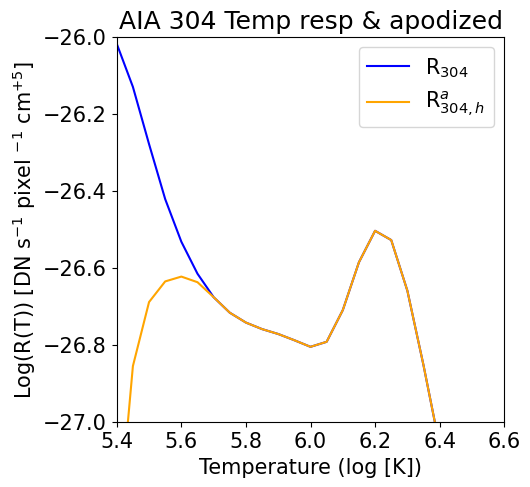

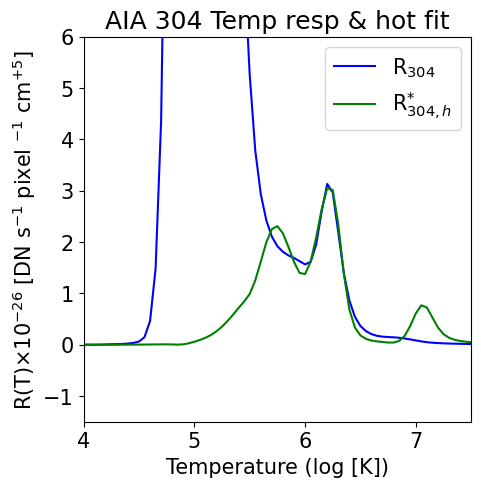

In [43]:
from scipy.optimize import leastsq
mydate = date
waveflag = [1,1,1,1,1,1]
method=2
mylogT=np.array([ 4.00000,4.05000,4.10000,4.15000,4.20000,4.25000,4.30000,4.35000,4.40000,4.45000,4.50000,4.55000,4.60000,4.65000,4.70000,4.75000,4.80000,4.85000,4.90000,4.95000,5.00000,5.05000,5.10000,5.15000,5.20000,5.25000,5.30000,5.35000,5.40000,5.45000,5.50000,5.55000,5.60000,5.65000,5.70000,5.75000,5.80000,5.85000,5.90000,5.95000,6.00000,6.05000,6.10000,6.15000,6.20000,6.25000,6.30000,6.35000,6.40000,6.45000,6.50000,6.55000,6.60000,6.65000,6.70000,6.75000,6.80000,6.85000,6.90000,6.95000,7.00000,7.05000,7.10000,7.15000,7.20000,7.25000,7.30000,7.35000,7.40000,7.45000,7.50000,7.55000,7.60000,7.65000,7.70000,7.75000,7.80000,7.85000,7.90000,7.95000,8.00000,8.05000,8.10000,8.15000,8.20000,8.25000,8.30000,8.35000,8.40000,8.45000,8.50000,8.55000,8.60000,8.65000,8.70000,8.75000,8.80000,8.85000,8.90000,8.95000,9.00000 ])
mylogTc = 6.205
temp_zero = 5.32
temp_cut = 5.75
sigmawindow = 1.0
oplot = 1
out=get_hot_coeff_for_date(first_guess,date,method,mylogTc,sigmawindow,temp_zero,temp_cut,waveflag,oplot)
print(out[0])
constants = out[0]

In [26]:
# Calculate the hot and cool components of AIA 304 with RFit method:
AIA304cool_min = np.zeros((data304.shape[0], data304.shape[1]))
AIA304hot_min = np.zeros((data304.shape[0], data304.shape[1]))

Xth = np.zeros((1,6,data304.shape[0], data304.shape[1]))
synth304Map = np.zeros((data304.shape[0], data304.shape[1]))
Xth[0,0,:,:] = data094.copy()
Xth[0,1,:,:] = data131.copy()
Xth[0,2,:,:] = data171.copy()
Xth[0,3,:,:] = data193.copy()
Xth[0,4,:,:] = data211.copy()
Xth[0,5,:,:] = data335.copy()
Xth304 = np.squeeze(data304)

# Produce hot 304 component:
for i in range(0,6):
    AIA304hot_min += Xth[0][i] * constants[i]

#Produce cold 304 component:
AIA304cool_min = Xth304 - AIA304hot_min

Text(0.5, 1.0, 'DN/s')

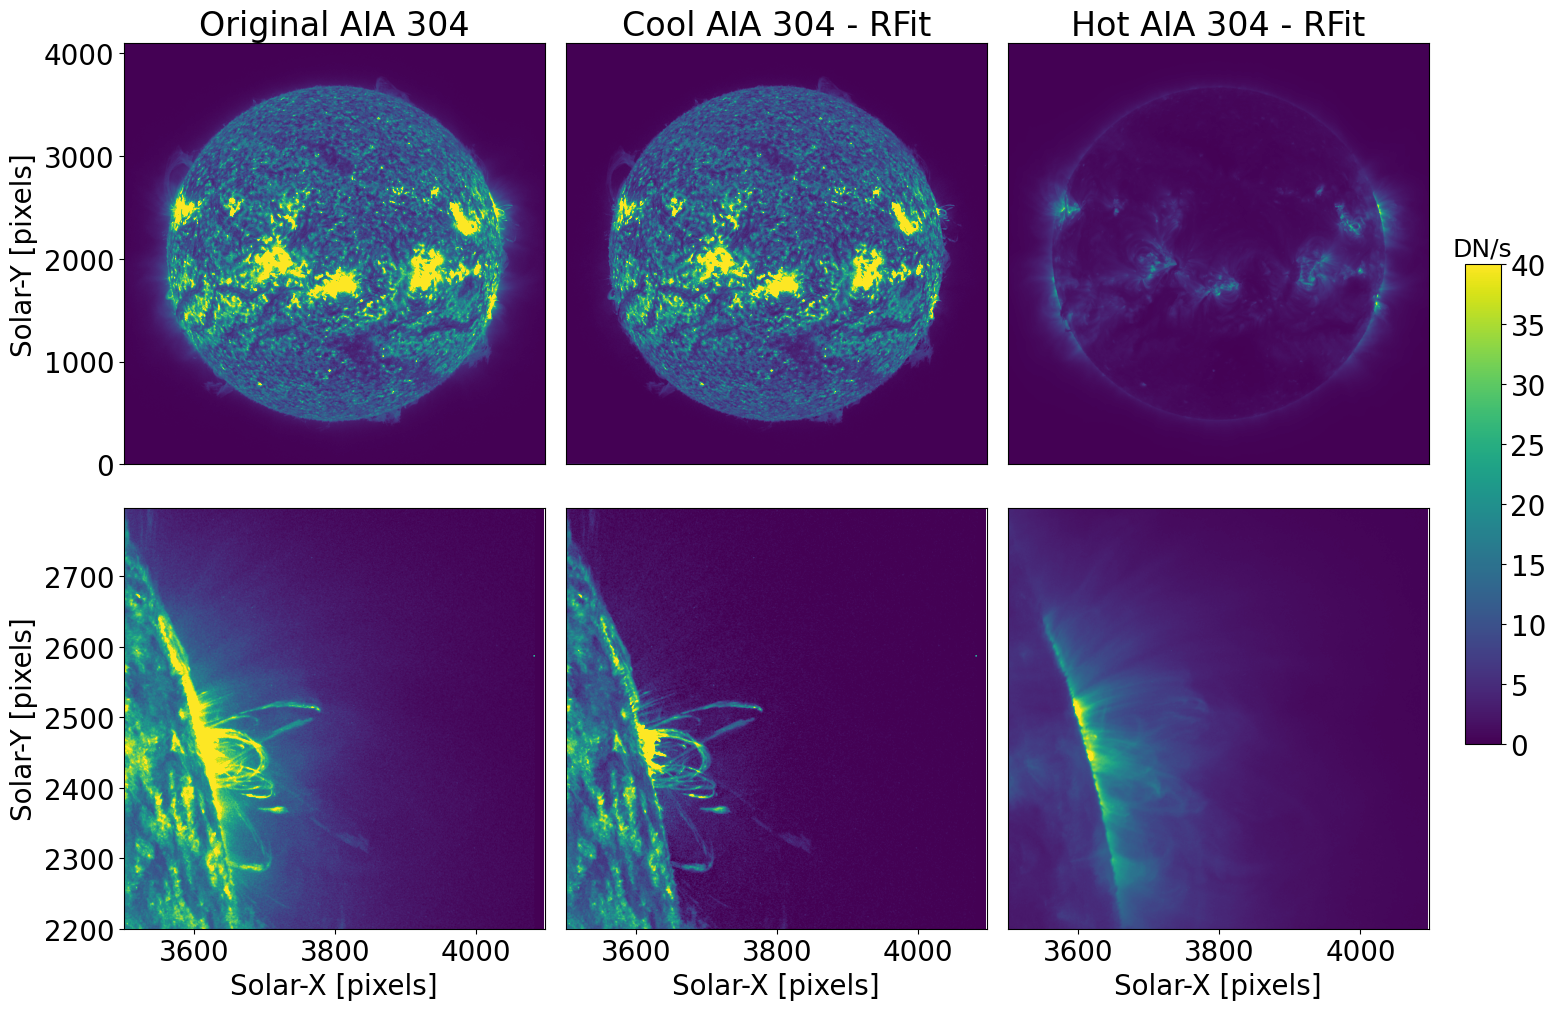

In [37]:
# Plot result
i = 0
vmax = 40
x0 = 3500
x1 = 4097
y0 = 2200
y1 = y0+(x1-x0)
plt.rcParams.update({'font.size': 20})
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(18,12))
fig.subplots_adjust(wspace=0.05,hspace=0.01)
im1 = ax[0,0].imshow(data304,vmin=0,vmax=vmax,origin='lower')
ax[0,0].set_title('Original AIA 304')
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].set_ylabel('Solar-Y [pixels]')
im2 = ax[0,1].imshow(AIA304cool_min,vmin=0,vmax=vmax,origin='lower')
ax[0,1].set_title('Cool AIA 304 - RFit')
ax[0,1].get_xaxis().set_visible(False)
ax[0,1].get_yaxis().set_visible(False)
im3 = ax[0,2].imshow(AIA304hot_min,vmin=0,vmax=vmax,origin='lower')
ax[0,2].set_title('Hot AIA 304 - RFit')
ax[0,2].get_xaxis().set_visible(False)
ax[0,2].get_yaxis().set_visible(False)
im4 = ax[1,0].imshow(data304,vmin=0,vmax=vmax,origin='lower')
ax[1,0].set_xlabel('Solar-X [pixels]')
ax[1,0].set_ylabel('Solar-Y [pixels]')
ax[1,0].set_xlim(x0,x1)
ax[1,0].set_ylim(y0,y1)
im5 = ax[1,1].imshow(AIA304cool_min,vmin=0,vmax=vmax,origin='lower')
ax[1,1].set_xlabel('Solar-X [pixels]')
ax[1,1].get_yaxis().set_visible(False)
ax[1,1].set_xlim(x0,x1)
ax[1,1].set_ylim(y0,y1)
im6 = ax[1,2].imshow(AIA304hot_min,vmin=0,vmax=vmax,origin='lower')
ax[1,2].set_xlabel('Solar-X [pixels]')
ax[1,2].get_yaxis().set_visible(False)
ax[1,2].set_xlim(x0,x1)
ax[1,2].set_ylim(y0,y1)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.28, 0.02, 0.4])
cb = fig.colorbar(im3,cax=cbar_ax)
cb.ax.set_title('DN/s',fontsize=18)